### Helper Function

In [1]:
from PIL import Image

def get_screenshot_as_img(
    obj,
    driver=None, 
    timeout: int=5,
    resources=None,
    width: int = None, 
    height: int = None,
) -> Image.Image:
    ''' Get a screenshot of a ``LayoutDOM`` object.

    Args:
        obj (LayoutDOM or Document) : a Layout (Row/Column), Plot or Widget
            object or Document to export.

        driver (selenium.webdriver) : a selenium webdriver instance to use
            to export the image.

        timeout (int) : the maximum amount of time to wait for initialization.
            It will be used as a timeout for loading Bokeh, then when waiting for
            the layout to be rendered.

    Returns:
        image (PIL.Image.Image) : a pillow image loaded from PNG.

    .. warning::
        Responsive sizing_modes may generate layouts with unexpected size and
        aspect ratios. It is recommended to use the default ``fixed`` sizing mode.

    '''
    import io
    
    from bokeh.io.webdriver import webdriver_control
    from bokeh.io.export import (
        _tmp_html, 
        INLINE, 
        get_layout_html, 
        wait_until_render_complete,
        _maximize_viewport,
    )

    with _tmp_html() as tmp:
        html = get_layout_html(obj, resources=resources or INLINE, width=width, height=height)
        with open(tmp.path, mode="w", encoding="utf-8") as file:
            file.write(html)

        web_driver = driver if driver is not None else webdriver_control.get()
        web_driver.maximize_window()
        web_driver.get(f"file://{tmp.path}")
        wait_until_render_complete(web_driver, timeout)
        [width, height, dpr] = _maximize_viewport(web_driver)
        png = web_driver.get_screenshot_as_png()

    return Image.open(io.BytesIO(png)).crop((0, 0, width*dpr, height*dpr))

### Firefox Driver

In [2]:
from selenium import webdriver
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary

profile = webdriver.FirefoxProfile()
# This paramter pushes up the pixels in the final image. 
# It's 1.0 by default and that causes a fair amount of blur.
profile.set_preference('layout.css.devPixelsPerPx','3.5')

options = webdriver.firefox.options.Options()
options.add_argument("--headless")

driver_firefox = webdriver.Firefox(
    firefox_profile=profile,
    firefox_binary=FirefoxBinary('/Applications/Firefox.app/Contents/MacOS/firefox'),
    executable_path='/opt/homebrew/bin/geckodriver',
    options=options,
    service_log_path='/dev/null',
)

### Chrome Driver

In [3]:
from selenium import webdriver

options = webdriver.chrome.options.Options()
options.add_argument("--headless")
options.add_argument("--hide-scrollbars")
# This is enabled in Bokeh and causes lots of blur.
# options.add_argument("--force-device-scale-factor=3")
options.add_argument("--force-color-profile=srgb")
driver_chrome = webdriver.Chrome(options=options)

### Bokeh In-Notebook Rendering

In [4]:
from bokeh.plotting import figure, output_notebook, show

output_notebook()

fig = figure(
    plot_width=900, 
    plot_height=400,
    title='A Plot',
    x_axis_label='X Axis',
    y_axis_label='Y Axis',
    y_axis_type='log',
)

fig.line(
    x=list(range(50)),
    y=list(range(50)),
)

fig.toolbar_location = None

show(fig)

Loading BokehJS ...

Manual screen capture from graph above:

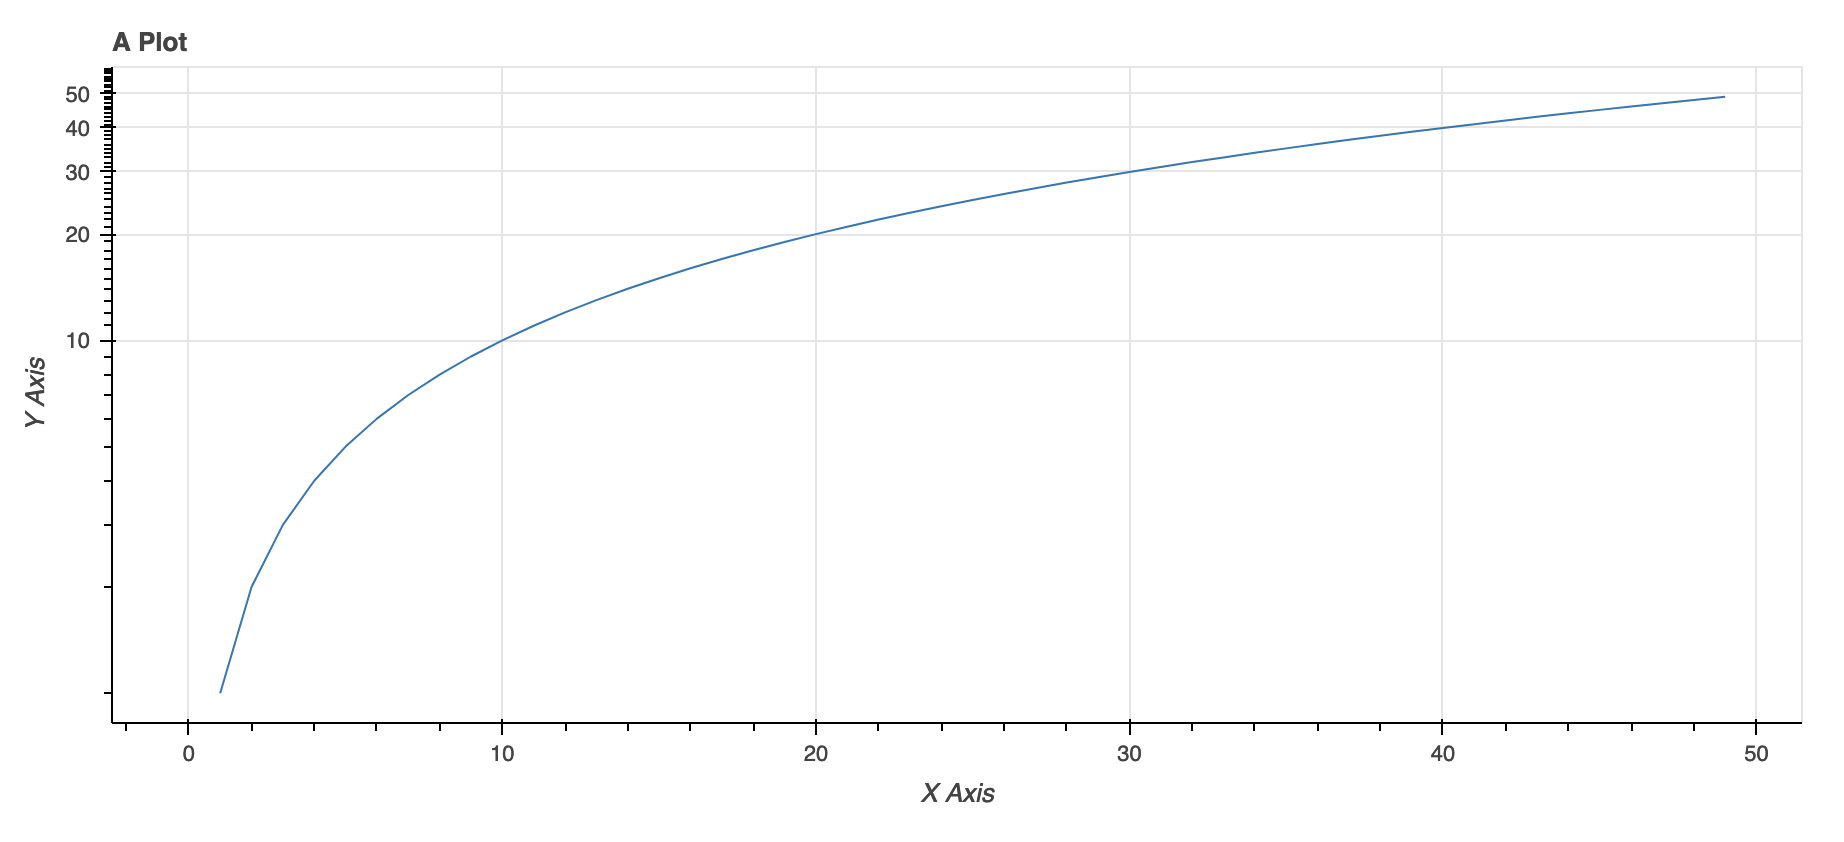

### Firefox Image

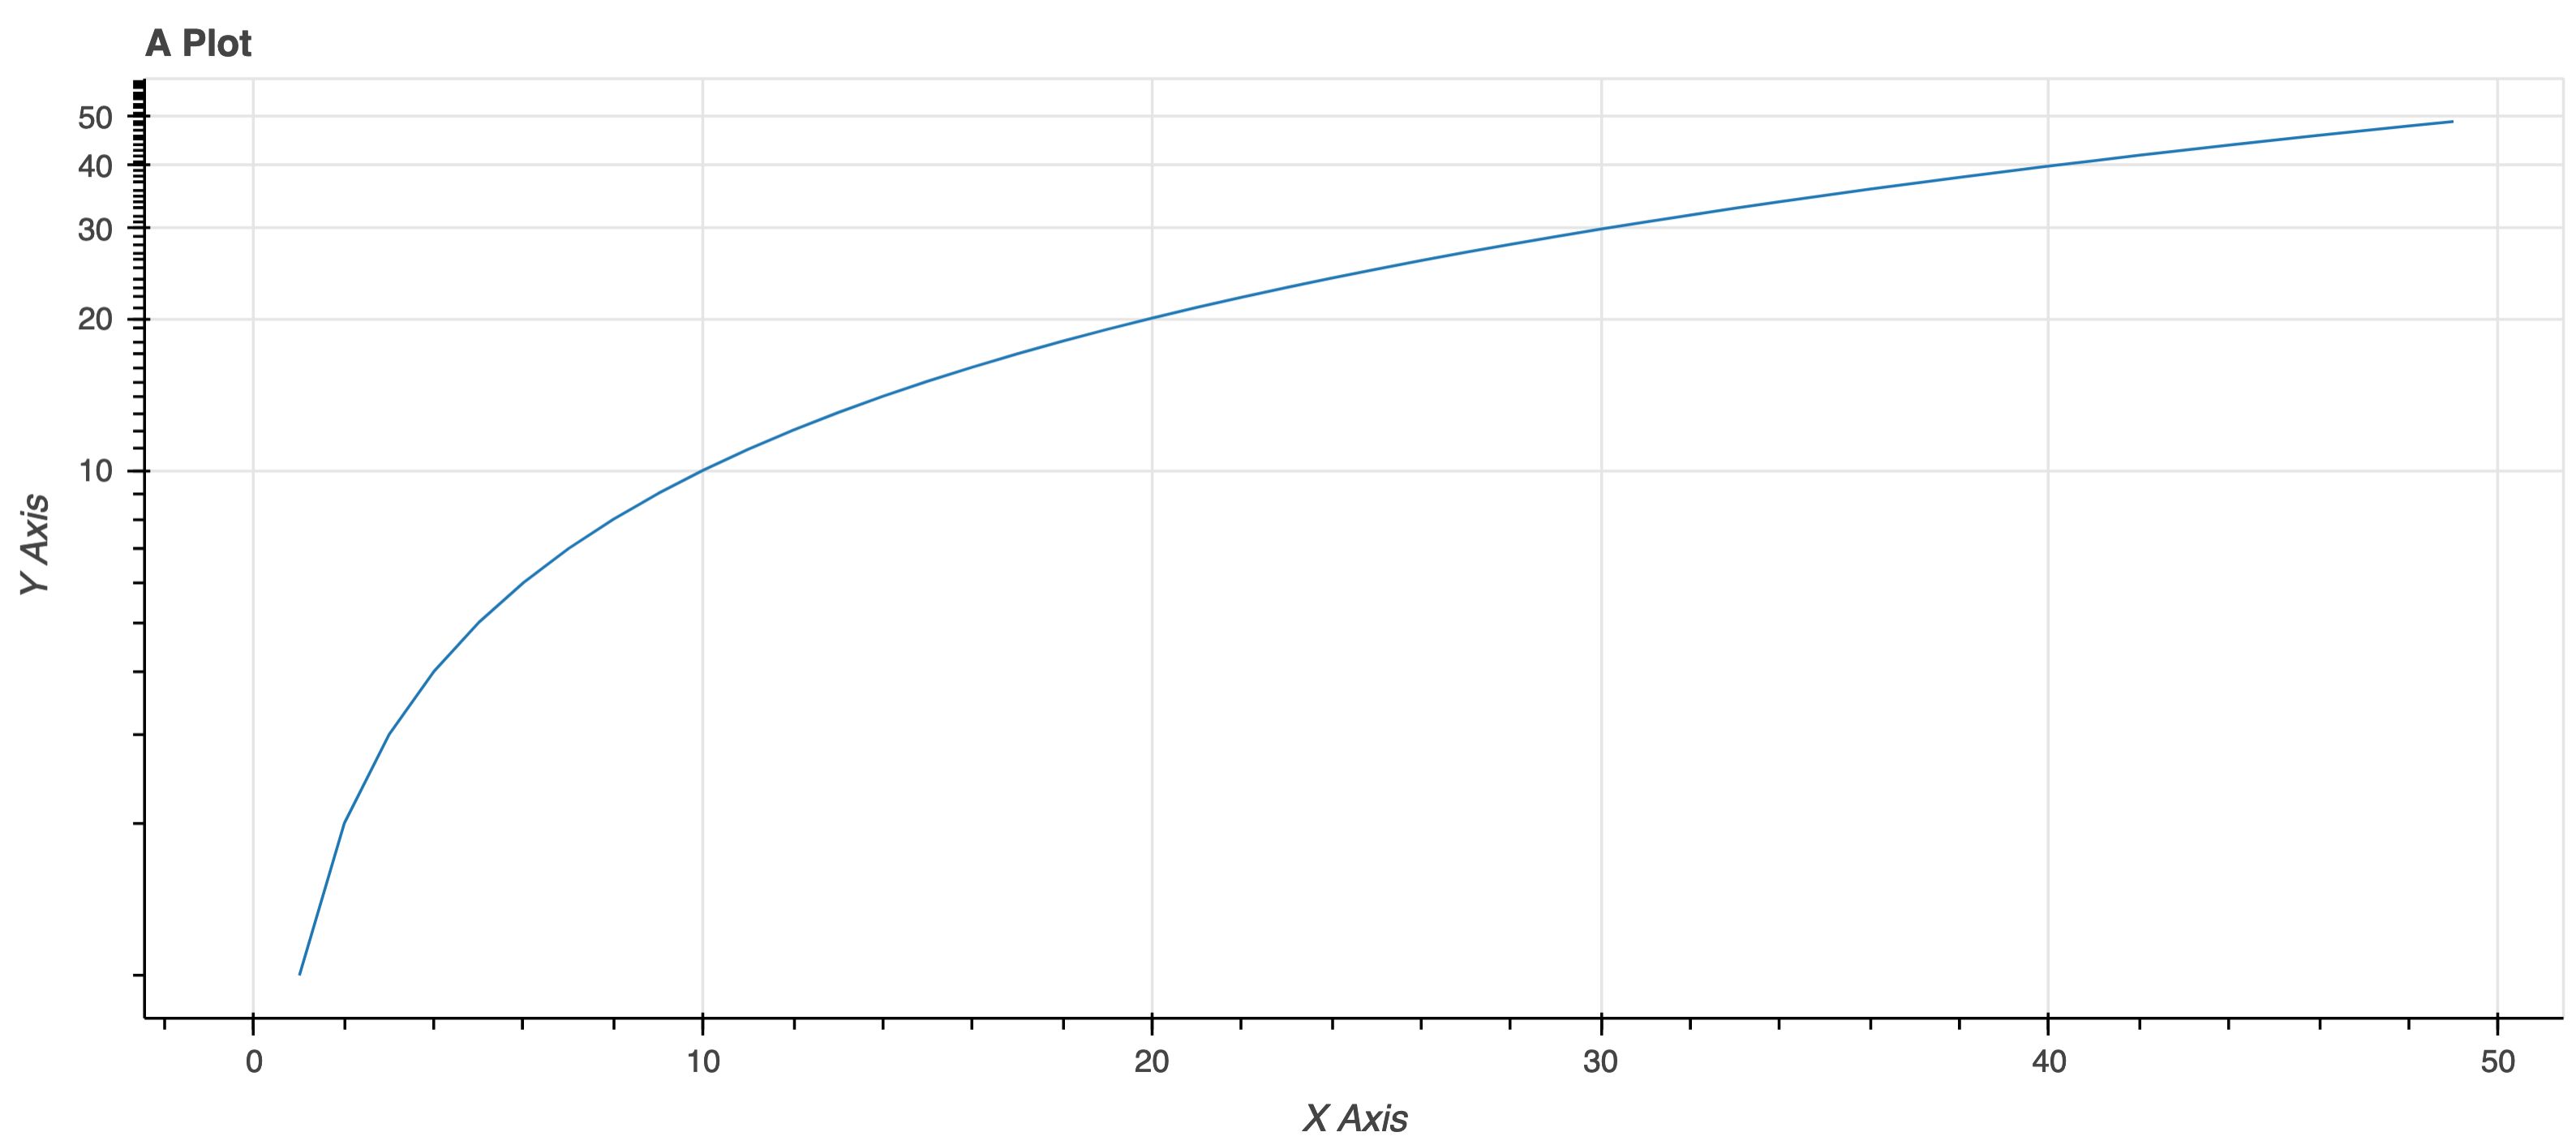

In [5]:
img_firefox = get_screenshot_as_img(
    fig,
    width=900,
    height=400,
    driver=driver_firefox,
)
img_firefox

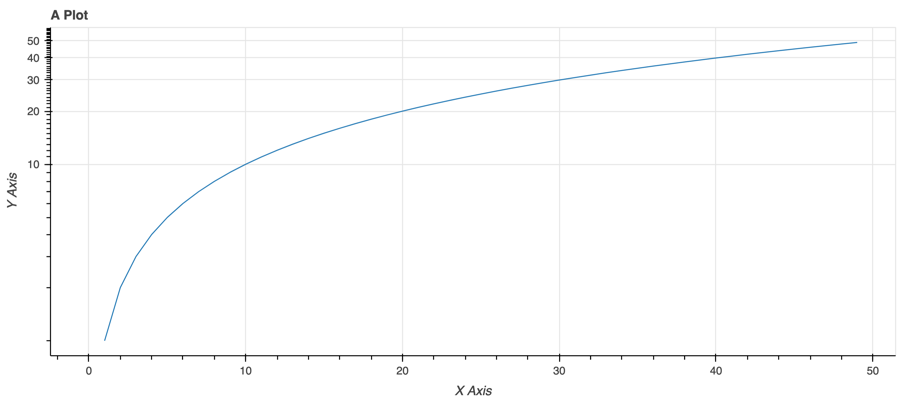

In [6]:
img_firefox.resize((900, 400))

### Chrome Image

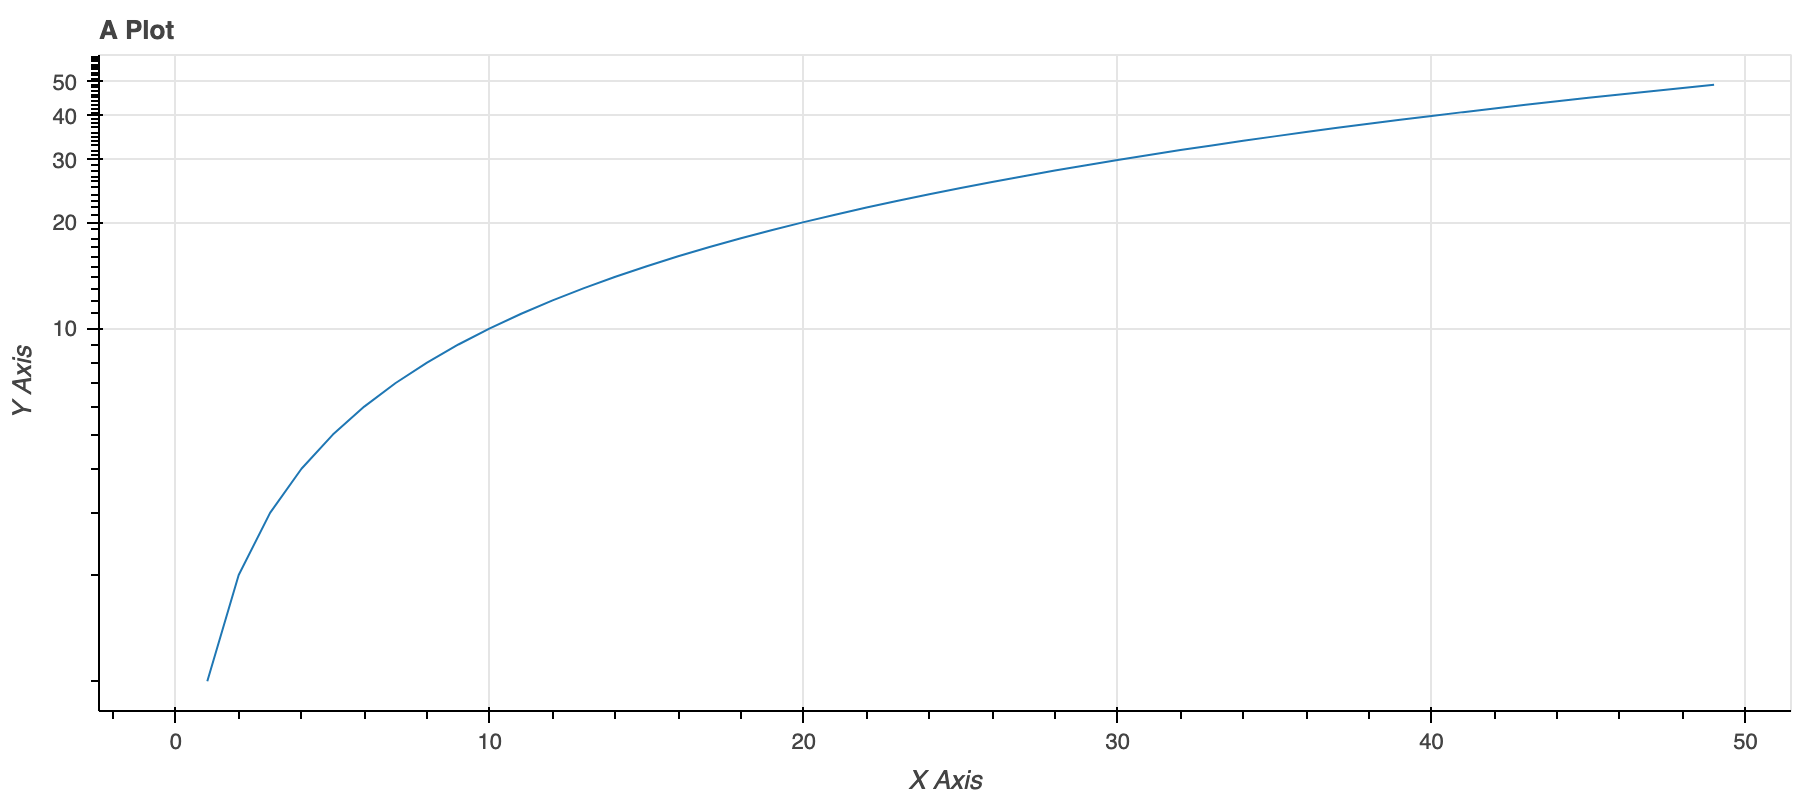

In [7]:
img_chrome = get_screenshot_as_img(
    fig,
    width=900,
    height=400,
    driver=driver_chrome,
)
img_chrome

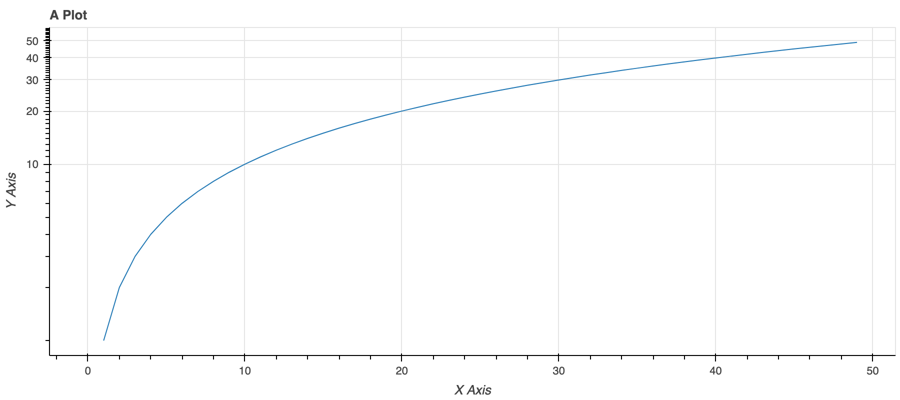

In [8]:
img_chrome.resize((900, 400))

### Defaults

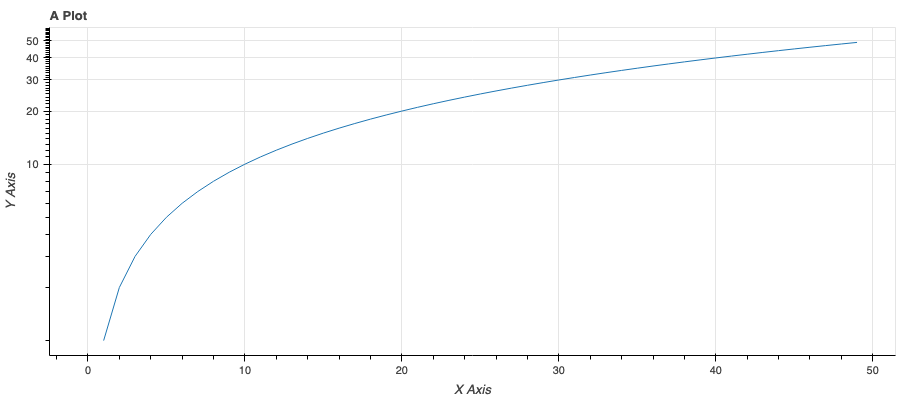

In [9]:
img = get_screenshot_as_img(
    fig,
    width=900,
    height=400,
)
img

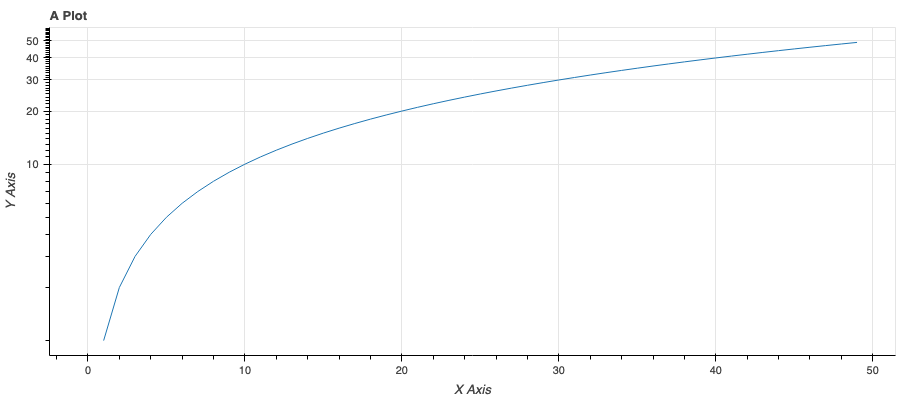

In [10]:
img.resize((900, 400))